# Sentinel 1

The following notebook illustrates the workflow with Sentinel 1 data.
#### Sentinel 1 data
This notebook does not process the sentinel 1 data. Instead it used already processed data.
The data can be processed with e.g. ESA's SNAP software. For many images, the graph builder and GPT batches are useful.

#### Contensts
The notebook contains functions and descriptons of:
- getting paths of many images
- loadning many images with found path
- slizing many images to fit e.g. a cnn model
- plotting image
- getting statistics



For Sentinel 1, a usefull package is gdal. This enables geocoding and more. 

In [2]:
from osgeo import gdal
import math
from matplotlib import pyplot as plt
import numpy as np
import os
from glob import glob

Designate a folder.
The function s1toimg will then take all files withing the folder, and all subfolders containing a specific extention.
Bear im mind, that no processing of s1 is done in python. This has all been done in Snap using batches. Therefore, the path must point to processed data!


In [3]:
import os
from glob import glob
import math
from matplotlib import pyplot as plt
import math


def s1toimg(path='',verbose=1,file_type='tif'):
    """
    Takes a path, finding all sentinel 1 images in the dir and sub dir, 
    and load those pics into python using gdal..
    
    
    inputs
        path[str]: string of path. 
        verbose[int]: information. If verbose>0 info will be printed.
        file_type[str]: extention of files. Default is .tif files.
        
    output:
        file_paths[str]: table of path strings.
        
    Example:
        temp = s1toimg('C:\\Users\\krist\\s1',verbose=0)
        temp = s1toimg('C:\\Users\\krist\\s1',verbose=1)
        temp = s1toimg('C:\\Users\\krist\\s1',verbose=2)   
        
    Author: 
        Kristian Aalling Soerensen
        10. May 2020
        kristian.sorensen@hotmail.com
    """
    allowed_types = ['tif','png','jp2','dim']
    assert (file_type in allowed_types),('\nERROR: '+file_type+': Illegal file type.')
    
    #getting current dir.
    cwd = os.getcwd()
    file_paths = []
    
    if path is '':
        start_dir = os.getcwd()
    
    if path is not '':
        start_dir = path
        if verbose>1:
            print('\nChangin dir to: '+start_dir)

    
    
    extention   = "*."+file_type
    for dir,_,_ in os.walk(start_dir):
        file_paths.extend(glob(os.path.join(dir,extention))) 
    
    assert len(file_paths)>0, ('\nERROR: No files of type:'+file_type+' in dir.')
    
    if verbose>0:
        print('\nthere are:',len(file_paths),' .',file_type,' files in folder')
    if verbose>1:
        print(file_paths)
    
    os.chdir(cwd)
    if verbose>1:
        print('\n Changin dir to: '+cwd)
        
    return file_paths

def get_images(path):
    """
        This function loads all images defined by path.
        For each path, an image and raster data will be saved.
        
        input:
            path[str]: a table containing strings
        
        output:
            images[array]: A table containing all the images in numpy format
            rasters[raster]: A table containing all the raster data.
        
        Example:
            images, raster = get_images(path)
            images, raster = get_images(path[0])
            images, raster = get_images(path[2])
            
        Author:
            Kristian Aalling Soerensen
            10. May 2020
            kristian.sorensen@hotmail.com
    """
    
    images = []
    rasters =[]
    for i in range(len(path)):
        raster = gdal.Open(path[i])
        rasters.append(raster)
        rb = raster.GetRasterBand(1)
        img_array = rb.ReadAsArray()
        print('a')
        #img_array = np.clip(img_array, np.quantile(img_array, 0.1), np.quantile(img_array, 0.9), out=img_array)
        img_array = np.clip(img_array, np.quantile(img_array, 0.1), np.quantile(img_array, 0.9))
        img_array = img_array/(img_array.max()/255.0)
        images.append(img_array)
        
    return images, rasters


def plot_images(images,path=''):
    """
        function plot sar images
        
    """
    
    fig, axs = plt.subplots(math.ceil(len(images)/2),2, figsize=(12,12), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    
    for i in range(len(images)):
        axs[i].imshow(images[i],cmap='binary')
        #axs[i].imshow(images[i],cmap='RdYlBu')
        axs[i].axis('off')
        if path!='':
            axs[i].set_title(path[i][17:21]+'-'+path[i][21:23]+'-'+path[i][23:25])
        
    return None

def get_raster_info(raster):
    """
        takes raster
    """
    projections = []
    meta_data = []
    number_bands = []
    dimensions = []
    
    for i in range(len(raster)):
        projections.append(raster[i].GetProjection())
        meta_data.append(raster[i].GetMetadata())
        number_bands.appenmd(raster[i].RasterCount)
        x = raster[i].RasterXSize
        y = raster[i].RasterYSize
        dimensions.append([x,y])
        
        
    return projections, meta_data

def get_subsets(img):
    """
        The following function takes in images, and split them up in subsets of same size.
        These subsets can then be used to e.g. train a network
        There is an overlap in the subsets. 
        
        input:
            img[array]: table of numpy images.
            
        output:
            subsets_image[array]: A table containing all the subsets of size 800.
            
        Example:
            subsets = get_subsets(list_of_img)
                gets subsets for a list of many images.
            subsets = get_subsets(list_of_img[1])
                get subsets from the second image in a list.
            
        Author:
            Kristian Aalling Soerensen
            10. May 2020
            kristian.sorensen@hotmail.com
    """
    subsets_image = []
    #the size of the subsets are hardcoded since this value should be the same and never changed!
    size = 800
    half = int(math.ceil(size/2))
    for i in range(len(img)):
        rows, colums = img.shape
        subsets = [];          
        for i in range(half,colums-half,half):
            for j in range(half,rows-half,half):
                temp = img[i-half:i+half,j-half:j+half];
                subsets.append(temp)
                
        subsets_image.append(subsets)
    # NOTE!! NAAR JEG FAAR DATA, SKAL DE LABLES!!
    # np.stack((r,g, b), axis=2)
    return subsets_image 

def get_statistics(raster):
    """
        get stats
    """
    stats = []
    
    for i in range(len(raster)):
        band = raster[i].GetRasterBand(1)
        no_data = band.GetNoDataValue()
        minimum = band.GetMinimum()
        maximum = band.GetMaximum()
        stats.append([no_data,minimu,maksimum])
        
    return stats

In [14]:
help(s1toimg)

Help on function s1toimg in module __main__:

s1toimg(path='', verbose=1, file_type='tif')
    Takes a path, finding all sentinel 1 images in the dir and sub dir, 
    and load those pics into python using gdal..
    
    
    inputs
        path[str]: string of path. 
        verbose[int]: information. If verbose>0 info will be printed.
        file_type[str]: extention of files. Default is .tif files.
        
    output:
        file_paths[str]: table of path strings.
        
    Example:
        temp = s1toimg('C:\Users\krist\s1',verbose=0)
        temp = s1toimg('C:\Users\krist\s1',verbose=1)
        temp = s1toimg('C:\Users\krist\s1',verbose=2)   
        
    Author: 
        Kristian Aalling Soerensen
        10. May 2020
        kristian.sorensen@hotmail.com



In [7]:
#folder with images
pa = "C:\\Users\\krist\\Documents\\Syntese\\sokndal\\s1\\snap_processed\\short_processed\\batch4"
#pa = "C:\\Users\\krist\\Documents\\Syntese\\sokndal\\s1\\snap_processed\\short_processed\\batch8_10_5"

In [8]:
#getting paths for all images in folder and subfolders
temp = s1toimg(pa,verbose=1,file_type='tif')


there are: 10  . tif  files in folder


In [9]:
raster = gdal.Open(temp[2])
type(raster)
rb = raster.GetRasterBand(1)
img_array = rb.ReadAsArray()
img_array.shape

(7173, 8226)

In [10]:
type(raster)

osgeo.gdal.Dataset

In [13]:
import rasterio
#getting images and rasters for all images.
images, raster = get_images(temp)

a
a
a
a
a
a
a
a
a
a


# illustrating entire im

In [61]:
(raster[1]).GetProjection()


'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

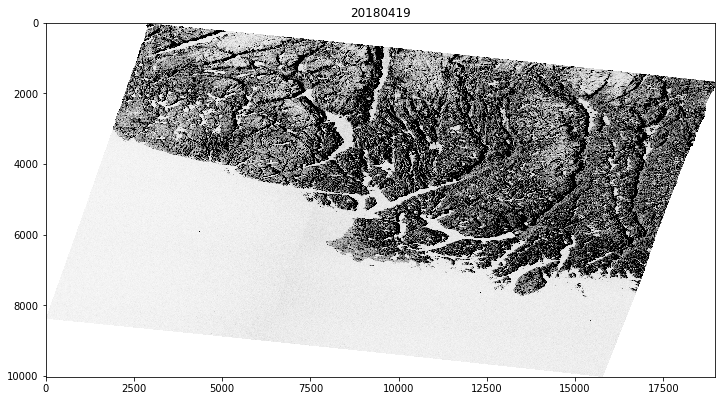

In [60]:
pic_name= (raster[1]).GetMetadata()["TIFFTAG_IMAGEDESCRIPTION"][24:32]
fig, axs = plt.subplots(figsize=(12,12), facecolor='w', edgecolor='k')
axs.imshow(images[1],cmap='binary')
#axs.axis('off')
plt.title(str(pic_name))
plt.show()

In [15]:
imagage = get_subsets(images[1])

Fromt he get_subsets() function, each sentinel 1 image has been slized. With a size of 800 pixels, each image has 400 subsets.
##### Illustrating subsets!
Here, 10 subsets from the first iamge is ilustrated

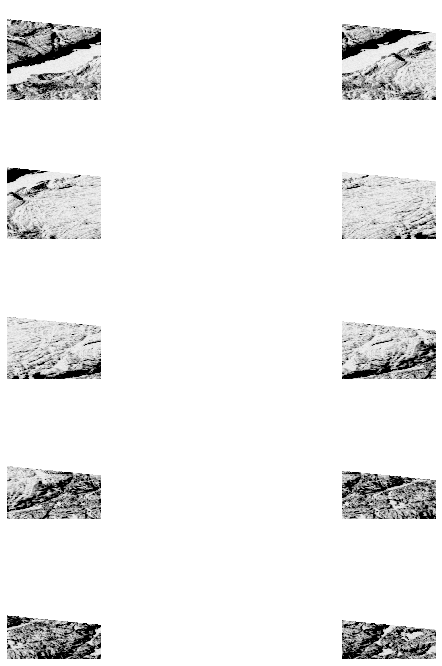

In [16]:
plot_images(imagage[0][10:20])

### Functions
To work with the sentinel 1 data, many different functions has been made.

For info on each of these, write e.g. help s1toimg

In [3]:


import math

def get_subsets(img):
    """
        The following function takes in images, and split them up in subsets of same size.
        
    """
    subsets_image = []
    #the size of the subsets are hardcoded since this value should be the same and never changed!
    size = 800
    half = int(math.ceil(size/2))
    for i in range(len(img)):
        rows, colums = img.shape
        subsets = [];          
        for i in range(half,colums-half,half):
            for j in range(half,rows-half,half):
                temp = img[i-half:i+half,j-half:j+half];
                subsets.append(temp)
                
        subsets_image.append(subsets)
    # NOTE!! NAAR JEG FAAR DATA, SKAL DE LABLES!!
    # np.stack((r,g, b), axis=2)
    return subsets_image
        

images = []
for i in range(len(tif)):
    raster = gdal.Open(tif[0])
    rb = raster.GetRasterBand(1)
    img_array = rb.ReadAsArray()
    img_array = np.clip(img_array, np.quantile(img_array, 0.1), np.quantile(img_array, 0.9), out=img_array)
    img_array = img_array/(img_array.max()/255.0)
    images.append(img_array)
    


import math
from matplotlib import pyplot as plt


fig, axs = plt.subplots(math.ceil(len(images)/2),2, figsize=(12,12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(len(images)):
    axs[i].imshow(images[i])
    axs[i].axis('off')
    axs[i].set_title(tif[i][17:21]+'-'+tif[i][21:23]+'-'+tif[i][23:25])




NameError: name 'tif' is not defined

In [ ]:
path = temp[1]

with rasterio.open(path) as src, MemoryFile() as memfile:
    array = src.read(1)
    rotation = np.rot90(array)
    x_pixels = array.shape[1]
    y_pixels = array.shape[0]
    profile = dict(src.profile)
    profile.update({'width': x_pixels, 'height': y_pixels})
    with memfile.open(**profile) as dataset:
        dataset.write(np.array([rotation]))
        # Remaining code
